In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=4b1ef9343779b3e0a76474441311691496608153eea509a9df863be2e3cff9f2
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [3]:
!pip uninstall numpy -y
!pip install "numpy<2"  # Installs latest 1.x version (1.26.4 as of 2025)

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 24.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [4]:
!pip install --force-reinstall --no-cache-dir pmdarima darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 151.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 197.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 208.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 172.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.7/169.7 kB 190.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 165.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.5/102.5 kB 303.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 kB 148.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 314.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 377.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 222.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 903.1/903.1 kB 403.0 MB/s eta 0:00

# Libraries

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import month_plot, quarter_plot, plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import ParameterSampler
import yfinance as yf
import ta
import os

# From darts
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import TSMixerModel

In [58]:
# Define the ticker symbol (for NSE)
ticker_symbol = "ASHOKLEY.NS"

# Fetch data from Yahoo Finance, including 'Adj Close'
data = yf.download(ticker_symbol, start="2019-01-01" , auto_adjust = False)

# Define file path to save the data
data_file_location = "/content/data/"
os.makedirs(data_file_location, exist_ok=True)

data_file_name = "AshokLeyLand"
data_file_ext = "csv"
file_path = f"{data_file_location}{data_file_name}.{data_file_ext}"

# Save the downloaded data to CSV
data.reset_index(inplace=True)
data.to_csv(file_path, index=False)

# Now, read the data from the saved CSV file
data = pd.read_csv(file_path , skiprows = [1])
data["Date"] = pd.to_datetime(data["Date"])
# Rename columns to a simpler format
data.rename(columns={"Adj Close": "Adj_Close"}, inplace=True)

# Convert 'Date' column to datetime objects (if needed)
data["Date"] = pd.to_datetime(data["Date"])

# Save the cleaned data back
data.to_csv(file_path, index=False)

# Display first few rows
print(data.head())


[*********************100%***********************]  1 of 1 completed

        Date  Adj_Close       Close        High         Low        Open  \
0 2019-01-01  86.378334  102.500000  102.900002  100.849998  102.849998   
1 2019-01-02  84.229416   99.949997  102.300003   99.000000  102.050003   
2 2019-01-03  82.712524   98.150002  100.300003   97.900002   99.750000   
3 2019-01-04  81.574875   96.800003   98.750000   96.000000   98.150002   
4 2019-01-07  78.751755   93.449997   98.050003   93.050003   98.000000   

     Volume  
0  13384173  
1  40123864  
2  24374807  
3  24533568  
4  34348346  


In [59]:
data.shape

(1554, 7)

In [60]:
# Adding P/E ratio , Sector , Industry info
stock = yf.Ticker(ticker_symbol)
sector = stock.info.get("sector", "N/A")  # Sector
industry = stock.info.get("industry", "N/A")  # Industry
pe_ratio = stock.info.get("trailingPE", "N/A")  # P/E Ratio

print(f"Sector: {sector}, Industry: {industry}, P/E Ratio: {pe_ratio}")

Sector: Industrials, Industry: Farm & Heavy Construction Machinery, P/E Ratio: 22.715767


In [61]:
# Calculate Moving Averages
data["20MA"] = data["Adj_Close"].rolling(window=20).mean()  # 20-day SMA
data["50MA"] = data["Adj_Close"].rolling(window=50).mean()  # 50-day SMA
data["200MA"] = data["Adj_Close"].rolling(window=200).mean()  # 200-day SMA

# Calculate EMA
data["EMA"] = data["Adj_Close"].ewm(span=20, adjust=False).mean()  # 20-day EMA
data["50EMA"] = data["Adj_Close"].ewm(span=50, adjust=False).mean()  # 50-day EMA
data["200EMA"] = data["Adj_Close"].ewm(span=200, adjust=False).mean()  # 200-day EMA


# Extracting day of the week and month as cyclical features
data['Day_of_Week'] = data["Date"].dt.dayofweek  # Extract day of the week (0 = Monday, 6 = Sunday)
data['Month'] = data["Date"].dt.month


data['Close_Lag1'] = data['Adj_Close'].shift(1)
data['Close_Lag2'] = data['Adj_Close'].shift(2)

# Calculate 14-day RSI
data['RSI_14'] = ta.momentum.RSIIndicator(data['Adj_Close'], window=14).rsi()

# # Calculate 20-day EMA
# data['EMA_20'] = ta.trend.EMAIndicator(data['Adj_Close'], window=20).ema_indicator()

# Fill NaN values

data[["20MA", "50MA", "200MA", "EMA" , "50EMA" , "200EMA", "Close_Lag1" , "Close_Lag2" , "RSI_14" , "Day_of_Week" , "Month"]] = data[["20MA", "50MA", "200MA", "EMA" , "50EMA" , "200EMA", "Close_Lag1" , "Close_Lag2" , "RSI_14" , "Day_of_Week" , "Month"]].fillna(method="bfill")
# Reset index to include 'Date'
data.reset_index(inplace=True , drop = True)

# Display sample data
print(data.head())

        Date  Adj_Close       Close        High         Low        Open  \
0 2019-01-01  86.378334  102.500000  102.900002  100.849998  102.849998   
1 2019-01-02  84.229416   99.949997  102.300003   99.000000  102.050003   
2 2019-01-03  82.712524   98.150002  100.300003   97.900002   99.750000   
3 2019-01-04  81.574875   96.800003   98.750000   96.000000   98.150002   
4 2019-01-07  78.751755   93.449997   98.050003   93.050003   98.000000   

     Volume       20MA       50MA      200MA        EMA      50EMA     200EMA  \
0  13384173  78.050206  74.146327  70.248229  86.378334  86.378334  86.378334   
1  40123864  78.050206  74.146327  70.248229  86.173675  86.294063  86.356952   
2  24374807  78.050206  74.146327  70.248229  85.844042  86.153610  86.320689   
3  24533568  78.050206  74.146327  70.248229  85.437454  85.974052  86.273467   
4  34348346  78.050206  74.146327  70.248229  84.800721  85.690825  86.198624   

   Day_of_Week  Month  Close_Lag1  Close_Lag2     RSI_14  
0  

<ipython-input-61-047748aa04ad>:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[["20MA", "50MA", "200MA", "EMA" , "50EMA" , "200EMA", "Close_Lag1" , "Close_Lag2" , "RSI_14" , "Day_of_Week" , "Month"]] = data[["20MA", "50MA", "200MA", "EMA" , "50EMA" , "200EMA", "Close_Lag1" , "Close_Lag2" , "RSI_14" , "Day_of_Week" , "Month"]].fillna(method="bfill")


In [62]:
data.head()

Date  Adj_Close       Close        High         Low        Open  \
0 2019-01-01  86.378334  102.500000  102.900002  100.849998  102.849998   
1 2019-01-02  84.229416   99.949997  102.300003   99.000000  102.050003   
2 2019-01-03  82.712524   98.150002  100.300003   97.900002   99.750000   
3 2019-01-04  81.574875   96.800003   98.750000   96.000000   98.150002   
4 2019-01-07  78.751755   93.449997   98.050003   93.050003   98.000000   

     Volume       20MA       50MA      200MA        EMA      50EMA     200EMA  \
0  13384173  78.050206  74.146327  70.248229  86.378334  86.378334  86.378334   
1  40123864  78.050206  74.146327  70.248229  86.173675  86.294063  86.356952   
2  24374807  78.050206  74.146327  70.248229  85.844042  86.153610  86.320689   
3  24533568  78.050206  74.146327  70.248229  85.437454  85.974052  86.273467   
4  34348346  78.050206  74.146327  70.248229  84.800721  85.690825  86.198624   

   Day_of_Week  Month  Close_Lag1  Close_Lag2     RSI_14  
0            1      1   86.378334   86.378334  18.074079  
1            2      1   86.378334   86.378334  18.074079  
2            3      1   84.229416   86.378334  18.074079  
3            4      1   82.712524   84.229416  18.074079  
4            0      1   81.574875   82.712524  18.074079

In [63]:
data.dtypes

Date           datetime64[ns]
Adj_Close             float64
Close                 float64
High                  float64
Low                   float64
Open                  float64
Volume                  int64
20MA                  float64
50MA                  float64
200MA                 float64
EMA                   float64
50EMA                 float64
200EMA                float64
Day_of_Week             int32
Month                   int32
Close_Lag1            float64
Close_Lag2            float64
RSI_14                float64
dtype: object

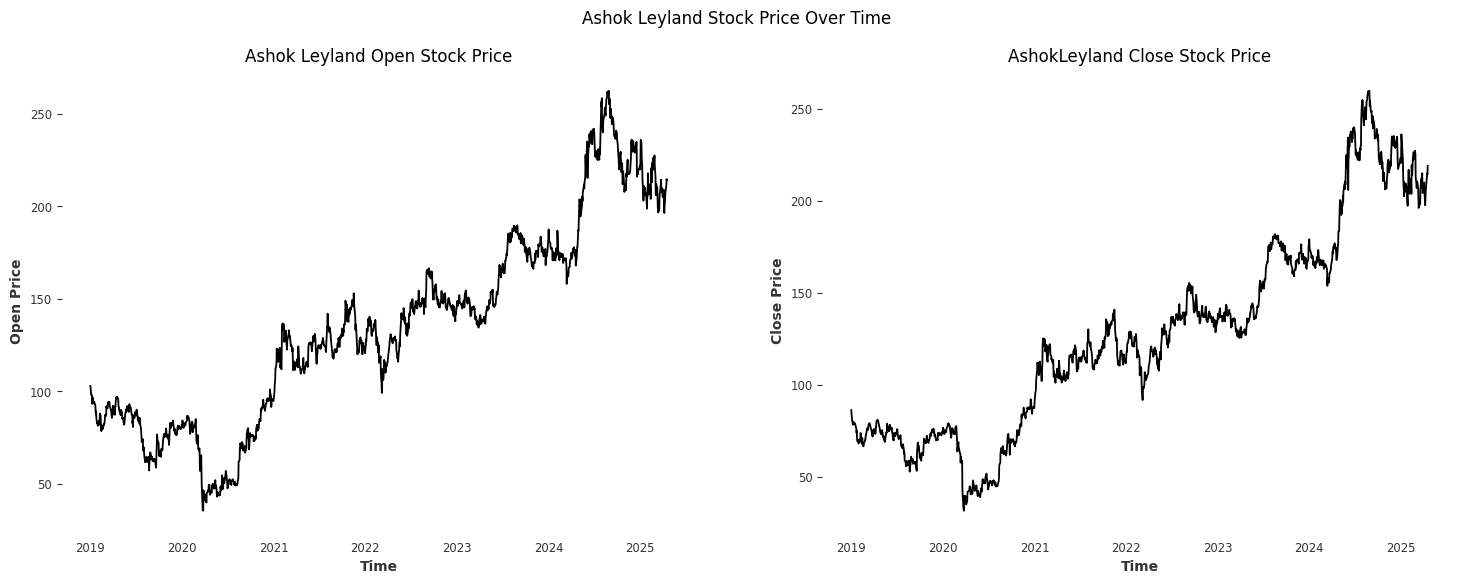

In [64]:
# Plot Open and Close price for the whole period
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.plot(data["Date"], data["Open"])
plt.xlabel("Time")
plt.ylabel("Open Price")
plt.title("Ashok Leyland Open Stock Price")
plt.grid()

plt.subplot(1,2,2)
plt.plot(data["Date"], data["Adj_Close"])
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.title("AshokLeyland Close Stock Price")
plt.grid()

plt.suptitle("Ashok Leyland Stock Price Over Time")
plt.show()

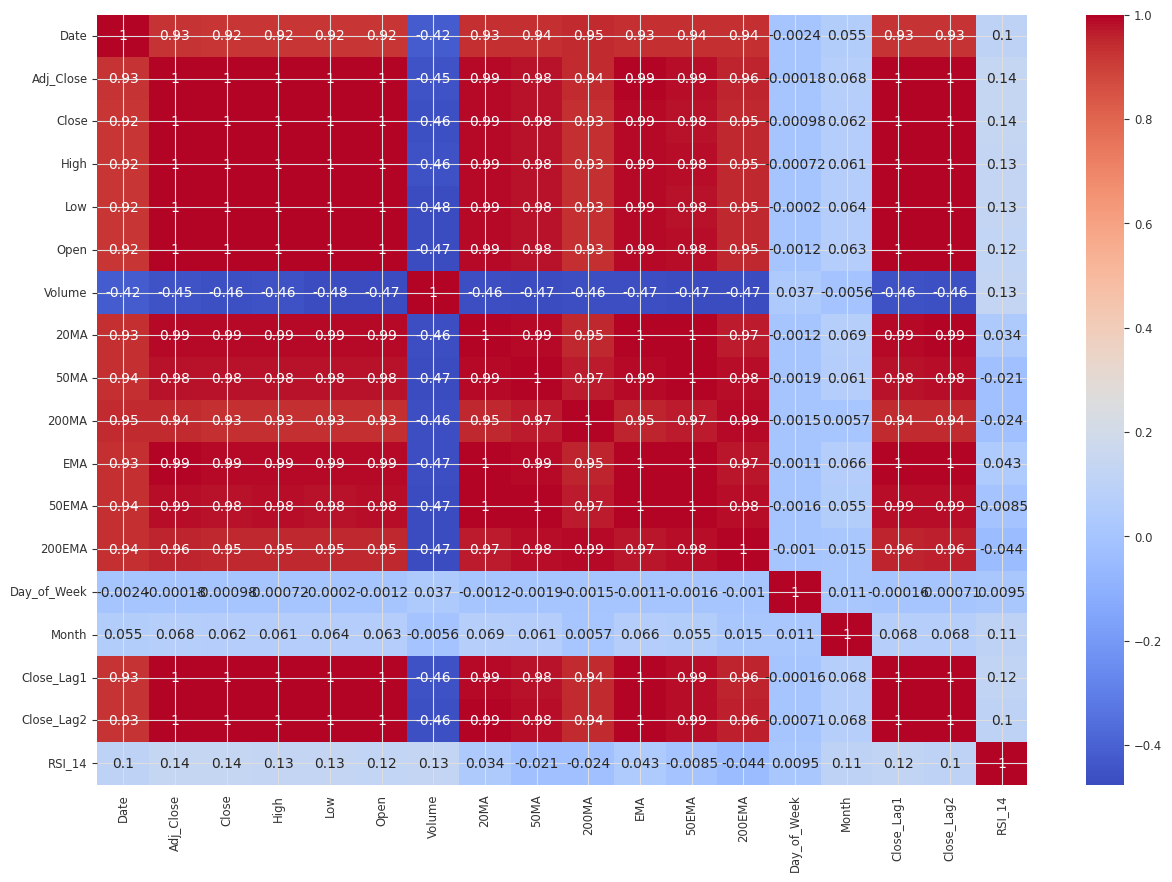

In [65]:
plt.figure(figsize=(15,10))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.show()

In [66]:
# Prepare data file location

data_file_location = "/content/drive/MyDrive/BTP"
if not os.path.exists(data_file_location):
    os.makedirs(data_file_location)
    print(f"Created directory: {data_file_location}")
else:
    print(f"Directory already exists: {data_file_location}")

data_file_name = "AshokLeyland_stock_price_recent"
data_file_ext = "csv"

# Store dataset
data.to_csv(data_file_location + data_file_name + "." + data_file_ext, index=None)

print(f"File saved at: {data_file_location}{data_file_name}.{data_file_ext}")

Directory already exists: /content/drive/MyDrive/BTP
File saved at: /content/drive/MyDrive/BTPAshokLeyland_stock_price_recent.csv


In [67]:
data.set_index('Date', inplace=True)

In [68]:
data = data.asfreq('D')

In [69]:
def encode_year(idx):
    return (idx.year - 2000) / 50

# Set up the add_encoders dictionary to specify how different time-related encoders and transformers are applied
add_encoders = {
    'cyclic': {'future': ['hour','day', 'dayofweek', 'week', 'month']},
    'datetime_attribute': {'future': ['day', 'dayofweek', 'week', 'month']},
    'position': {'past': ['relative'], 'future': ['relative']},
    'custom': {'past': [encode_year], 'future': [encode_year]},
    'transformer': Scaler(),
    'tz': 'CET'
}

In [70]:
scaler1 = Scaler()
scaler2 = Scaler()

In [71]:
data.rename(columns={'Adj_Close':'y'}, inplace=True)

In [72]:
data.fillna(method='bfill', inplace=True)

<ipython-input-72-11d55077a1df>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


In [73]:
series = TimeSeries.from_dataframe(data, value_cols='y', freq='D')

In [74]:
X_past = data.iloc[:, 1:]
past_covariates = TimeSeries.from_dataframe(X_past, freq='D')
past_covariates

<TimeSeries (DataArray) (Date: 2299, component: 16, sample: 1)> Size: 294kB
array([[[102.5       ],
        [102.90000153],
        [100.84999847],
        ...,
        [ 86.37833405],
        [ 86.37833405],
        [ 18.07407939]],

       [[ 99.94999695],
        [102.30000305],
        [ 99.        ],
        ...,
        [ 86.37833405],
        [ 86.37833405],
        [ 18.07407939]],

       [[ 98.15000153],
        [100.30000305],
        [ 97.90000153],
        ...,
...
        ...,
        [208.5       ],
        [204.67999268],
        [ 56.81497136]],

       [[214.3999939 ],
        [215.5       ],
        [212.86999512],
        ...,
        [214.94999695],
        [208.5       ],
        [ 56.20349486]],

       [[218.97999573],
        [219.3999939 ],
        [212.83000183],
        ...,
        [214.3999939 ],
        [214.94999695],
        [ 60.05851319]]], shape=(2299, 16, 1))
Coordinates:
  * Date       (Date) datetime64[ns] 18kB 2019-01-01 2019-01-02 ... 2025-04-17
  * component  (component) <U11 704B 'Close' 'High' ... 'Close_Lag2' 'RSI_14'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

In [75]:
series_scaled = scaler1.fit_transform(series)
past_covariates_scaled = scaler2.fit_transform(past_covariates)

In [76]:
# Define the Param Grid
param_grid = {
    'input_chunk_length':[7, 14, 28, 30],
    'n_epochs':[5,10,15],
    'ff_size':[3,5,7,9],
    'num_blocks':[2,4,6,8],
    'hidden_size':[5,7,9,11]
}

In [77]:
# Define the fixed params
fixed_params = {
    'output_chunk_length':7,
    'add_encoders':add_encoders,
    'use_reversible_instance_norm':True,
    'pl_trainer_kwargs':{'accelerator':'gpu', 'devices':[0]}
}

In [78]:
param_list = list(ParameterSampler(param_grid, n_iter = 25))

In [79]:
for params in param_list:
  params.update(fixed_params)

In [80]:
mape_7 = []
for param in param_list:
  model = TSMixerModel(**param)

  model.fit(series=series_scaled[:-7], past_covariates=past_covariates_scaled[:-7])
  mape_7.append(mape(series_scaled[-7:], model.predict(n=7)))
min(mape_7)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear           | 56     | train
7  | feature_mixing_hist   | _FeatureMixing   | 460

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear           | 427    | train
7  | feature_mixing_hist   | _FeatureMixing   | 2.6

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear           | 203    | train
7  | feature_mixing_hist   | _FeatureMixing   | 890

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear           | 203    | train
7  | feature_mixing_hist   | _FeatureMixing   | 542

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear           | 203    | train
7  | feature_mixing_hist   | _FeatureMixing   | 1.2

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear           | 217    | train
7  | feature_mixing_hist   | _FeatureMixing   | 594

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear           | 56     | train
7  | feature_mixing_hist   | _FeatureMixing   | 1.2

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear           | 105    | train
7  | feature_mixing_hist   | _FeatureMixing   | 1.9

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear           | 203    | train
7  | feature_mixing_hist   | _FeatureMixing   | 684

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear           | 105    | train
7  | feature_mixing_hist   | _FeatureMixing   | 796

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear           | 105    | train
7  | feature_mixing_hist   | _FeatureMixing   | 1.9

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear           | 105    | train
7  | feature_mixing_hist   | _FeatureMixing   | 594

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear           | 217    | train
7  | feature_mixing_hist   | _FeatureMixing   | 1.4

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear           | 105    | train
7  | feature_mixing_hist   | _FeatureMixing   | 460

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear           | 56     | train
7  | feature_mixing_hist   | _FeatureMixing   | 774

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear           | 427    | train
7  | feature_mixing_hist   | _FeatureMixing   | 1.3

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear           | 217    | train
7  | feature_mixing_hist   | _FeatureMixing   | 1.9

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear           | 56     | train
7  | feature_mixing_hist   | _FeatureMixing   | 744

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear           | 217    | train
7  | feature_mixing_hist   | _FeatureMixing   | 1.2

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear           | 217    | train
7  | feature_mixing_hist   | _FeatureMixing   | 890

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

np.float64(1.5273406255737532)

In [81]:
results_df = pd.DataFrame(param_list)
results_df['MAPE'] = mape_7
results_df

num_blocks  n_epochs  input_chunk_length  hidden_size  ff_size  \
0            8         5                   7            5        5   
1            6        15                  60           40        7   
2            4        10                  28           11        7   
3            8         5                  28            5        7   
4            6        10                  28           20        3   
5            6        15                  30            9        3   
6            4        10                   7           20        3   
7            2        10                  14           30        5   
8            6         5                  28            9        5   
9            8         5                  14           11        5   
10           4        10                  14           30        5   
11           8         5                  14            9        3   
12           2        15                  30           20        7   
13           8        15                  14            5        5   
14           4        15                   7            9        7   
15           6        15                  60           20        5   
16           8        10                  30           30        5   
17           2         5                   7            7        9   
18           6        15                  30           20        3   
19           2        10                  30           11        7   

    output_chunk_length                                       add_encoders  \
0                     7  {'cyclic': {'future': ['hour', 'day', 'dayofwe...   
1                     7  {'cyclic': {'future': ['hour', 'day', 'dayofwe...   
2                     7  {'cyclic': {'future': ['hour', 'day', 'dayofwe...   
3                     7  {'cyclic': {'future': ['hour', 'day', 'dayofwe...   
4                     7  {'cyclic': {'future': ['hour', 'day', 'dayofwe...   
5                     7  {'cyclic': {'future': ['hour', 'day', 'dayofwe...   
6                     7  {'cyclic': {'future': ['hour', 'day', 'dayofwe...   
7                     7  {'cyclic': {'future': ['hour', 'day', 'dayofwe...   
8                     7  {'cyclic': {'future': ['hour', 'day', 'dayofwe...   
9                     7  {'cyclic': {'future': ['hour', 'day', 'dayofwe...   
10                    7  {'cyclic': {'future': ['hour', 'day', 'dayofwe...   
11                    7  {'cyclic': {'future': ['hour', 'day', 'dayofwe...   
12                    7  {'cyclic': {'future': ['hour', 'day', 'dayofwe...   
13                    7  {'cyclic': {'future': ['hour', 'day', 'dayofwe...   
14                    7  {'cyclic': {'future': ['hour', 'day', 'dayofwe...   
15                    7  {'cyclic': {'future': ['hour', 'day', 'dayofwe...   
16                    7  {'cyclic': {'future': ['hour', 'day', 'dayofwe...   
17                    7  {'cyclic': {'future': ['hour', 'day', 'dayofwe...   
18                    7  {'cyclic': {'future': ['hour', 'day', 'dayofwe...   
19                    7  {'cyclic': {'future': ['hour', 'day', 'dayofwe...   

    use_reversible_instance_norm                       pl_trainer_kwargs  \
0                           True  {'accelerator': 'gpu', 'devices': [0]}   
1                           True  {'accelerator': 'gpu', 'devices': [0]}   
2                           True  {'accelerator': 'gpu', 'devices': [0]}   
3                           True  {'accelerator': 'gpu', 'devices': [0]}   
4                           True  {'accelerator': 'gpu', 'devices': [0]}   
5                           True  {'accelerator': 'gpu', 'devices': [0]}   
6                           True  {'accelerator': 'gpu', 'devices': [0]}   
7                           True  {'accelerator': 'gpu', 'devices': [0]}   
8                           True  {'accelerator': 'gpu', 'devices': [0]}   
9                           True  {'accelerator': 'gpu', 'devices': [0]}   
10                          True  {'accelerator': 'gpu', '

In [82]:
best_params = results_df.loc[results_df['MAPE'].idxmin()]
best_params.to_csv("best_params_tsmixer.csv")

In [83]:
best_params = best_params.drop('MAPE').to_dict()

In [84]:
# model = TSMixerModel(
#     input_chunk_length = 14,
#     output_chunk_length = 7,
#     add_encoders = add_encoders,
#     ff_size = 9,
#     num_blocks = 8,
#     hidden_size = 5,
#     n_epochs = 10,
#     use_reversible_instance_norm = True,
#     pl_trainer_kwargs = {"accelerator":"gpu", "devices":[0]}
# )
model = TSMixerModel(**best_params)
model.fit(series=series_scaled, past_covariates=past_covariates_scaled)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear           | 105    | train
7  | feature_mixing_hist   | _FeatureMixing   | 1.9

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


TSMixerModel(output_chunk_shift=0, hidden_size=30, ff_size=5, num_blocks=4, activation=ReLU, dropout=0.1, norm_type=LayerNorm, normalize_before=False, use_static_covariates=True, n_epochs=10, input_chunk_length=14, output_chunk_length=7, add_encoders={'cyclic': {'future': ['hour', 'day', 'dayofweek', 'week', 'month']}, 'datetime_attribute': {'future': ['day', 'dayofweek', 'week', 'month']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function encode_year at 0x7de64baef920>], 'future': [<function encode_year at 0x7de64baef920>]}, 'transformer': Scaler, 'tz': 'CET'}, use_reversible_instance_norm=True, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': [0]})

In [85]:
# Perform cross-validation with the rolling forecast
cv = model.historical_forecasts(
    series = series_scaled,
    past_covariates = past_covariates_scaled,
    start = 30,
    forecast_horizon = 7,
    retrain=True,
    verbose = True,
    last_points_only = False,
    stride = 7
)

historical forecasts:   0%|          | 0/324 [00:00<?, ?it/s]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear           | 105  

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:   0%|          | 1/324 [00:00<02:49,  1.90it/s]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:   1%|          | 2/324 [00:01<02:54,  1.85it/s]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:   1%|          | 3/324 [00:01<03:04,  1.74it/s]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:   1%|          | 4/324 [00:02<03:06,  1.72it/s]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:   2%|▏         | 5/324 [00:03<03:35,  1.48it/s]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:   2%|▏         | 6/324 [00:04<04:02,  1.31it/s]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:   2%|▏         | 7/324 [00:05<04:22,  1.21it/s]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:   2%|▏         | 8/324 [00:05<04:27,  1.18it/s]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:   3%|▎         | 9/324 [00:07<04:52,  1.08it/s]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:   3%|▎         | 10/324 [00:07<04:47,  1.09it/s]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:   3%|▎         | 11/324 [00:08<04:39,  1.12it/s]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:   4%|▎         | 12/324 [00:09<04:33,  1.14it/s]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:   4%|▍         | 13/324 [00:10<04:30,  1.15it/s]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:   4%|▍         | 14/324 [00:11<04:42,  1.10it/s]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:   5%|▍         | 15/324 [00:12<04:51,  1.06it/s]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:   5%|▍         | 16/324 [00:13<04:57,  1.04it/s]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:   5%|▌         | 17/324 [00:14<05:00,  1.02it/s]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:   6%|▌         | 18/324 [00:15<05:12,  1.02s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:   6%|▌         | 19/324 [00:16<05:23,  1.06s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:   6%|▌         | 20/324 [00:18<06:00,  1.19s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:   6%|▋         | 21/324 [00:19<06:30,  1.29s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:   7%|▋         | 22/324 [00:21<06:45,  1.34s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:   7%|▋         | 23/324 [00:22<06:38,  1.32s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:   7%|▋         | 24/324 [00:23<06:31,  1.31s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:   8%|▊         | 25/324 [00:25<06:29,  1.30s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:   8%|▊         | 26/324 [00:26<06:27,  1.30s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:   8%|▊         | 27/324 [00:27<06:25,  1.30s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:   9%|▊         | 28/324 [00:29<06:37,  1.34s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:   9%|▉         | 29/324 [00:30<06:43,  1.37s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:   9%|▉         | 30/324 [00:32<07:24,  1.51s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  10%|▉         | 31/324 [00:34<07:55,  1.62s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  10%|▉         | 32/324 [00:35<08:01,  1.65s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  10%|█         | 33/324 [00:37<07:53,  1.63s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  10%|█         | 34/324 [00:39<07:47,  1.61s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  11%|█         | 35/324 [00:40<07:45,  1.61s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  11%|█         | 36/324 [00:42<07:43,  1.61s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  11%|█▏        | 37/324 [00:44<07:48,  1.63s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  12%|█▏        | 38/324 [00:46<08:21,  1.75s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  12%|█▏        | 39/324 [00:48<09:02,  1.90s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  12%|█▏        | 40/324 [00:50<08:57,  1.89s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  13%|█▎        | 41/324 [00:52<08:53,  1.89s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  13%|█▎        | 42/324 [00:53<08:51,  1.88s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  13%|█▎        | 43/324 [00:55<08:44,  1.87s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  14%|█▎        | 44/324 [00:57<08:41,  1.86s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  14%|█▍        | 45/324 [00:59<08:57,  1.93s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  14%|█▍        | 46/324 [01:02<09:59,  2.16s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  15%|█▍        | 47/324 [01:04<09:52,  2.14s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  15%|█▍        | 48/324 [01:06<09:40,  2.10s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  15%|█▌        | 49/324 [01:08<09:27,  2.06s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  15%|█▌        | 50/324 [01:10<09:36,  2.10s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  16%|█▌        | 51/324 [01:12<09:47,  2.15s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  16%|█▌        | 52/324 [01:15<10:42,  2.36s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  16%|█▋        | 53/324 [01:18<10:44,  2.38s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  17%|█▋        | 54/324 [01:20<10:22,  2.31s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  17%|█▋        | 55/324 [01:22<10:19,  2.30s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  17%|█▋        | 56/324 [01:24<10:12,  2.29s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  18%|█▊        | 57/324 [01:27<10:16,  2.31s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  18%|█▊        | 58/324 [01:30<11:12,  2.53s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  18%|█▊        | 59/324 [01:32<10:58,  2.49s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  19%|█▊        | 60/324 [01:35<10:46,  2.45s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  19%|█▉        | 61/324 [01:37<10:35,  2.42s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  19%|█▉        | 62/324 [01:40<10:54,  2.50s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  19%|█▉        | 63/324 [01:43<11:34,  2.66s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  20%|█▉        | 64/324 [01:46<11:56,  2.76s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  20%|██        | 65/324 [01:48<11:40,  2.70s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  20%|██        | 66/324 [01:51<11:37,  2.70s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  21%|██        | 67/324 [01:54<11:48,  2.76s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  21%|██        | 68/324 [01:57<12:34,  2.95s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  21%|██▏       | 69/324 [02:00<12:37,  2.97s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  22%|██▏       | 70/324 [02:03<12:14,  2.89s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  22%|██▏       | 71/324 [02:06<12:06,  2.87s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  22%|██▏       | 72/324 [02:09<12:11,  2.90s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  23%|██▎       | 73/324 [02:12<13:08,  3.14s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  23%|██▎       | 74/324 [02:15<12:44,  3.06s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  23%|██▎       | 75/324 [02:18<12:26,  3.00s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  23%|██▎       | 76/324 [02:21<12:14,  2.96s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  24%|██▍       | 77/324 [02:25<12:59,  3.16s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  24%|██▍       | 78/324 [02:28<13:30,  3.29s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  24%|██▍       | 79/324 [02:31<13:27,  3.29s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  25%|██▍       | 80/324 [02:35<13:10,  3.24s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  25%|██▌       | 81/324 [02:38<13:49,  3.41s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  25%|██▌       | 82/324 [02:43<15:20,  3.81s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  26%|██▌       | 83/324 [02:46<14:32,  3.62s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  26%|██▌       | 84/324 [02:50<13:59,  3.50s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  26%|██▌       | 85/324 [02:53<14:28,  3.63s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  27%|██▋       | 86/324 [02:57<14:12,  3.58s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  27%|██▋       | 87/324 [03:00<13:52,  3.51s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  27%|██▋       | 88/324 [03:04<13:38,  3.47s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  27%|██▋       | 89/324 [03:08<14:35,  3.73s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  28%|██▊       | 90/324 [03:11<14:06,  3.62s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  28%|██▊       | 91/324 [03:15<13:44,  3.54s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  28%|██▊       | 92/324 [03:18<13:54,  3.60s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  29%|██▊       | 93/324 [03:23<15:01,  3.90s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  29%|██▉       | 94/324 [03:27<14:39,  3.82s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  29%|██▉       | 95/324 [03:30<14:28,  3.79s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  30%|██▉       | 96/324 [03:35<14:48,  3.90s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  30%|██▉       | 97/324 [03:39<15:00,  3.97s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  30%|███       | 98/324 [03:42<14:38,  3.89s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  31%|███       | 99/324 [03:46<14:20,  3.83s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear         

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  31%|███       | 100/324 [03:51<15:14,  4.08s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  31%|███       | 101/324 [03:55<14:57,  4.03s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  31%|███▏      | 102/324 [03:59<14:42,  3.97s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  32%|███▏      | 103/324 [04:03<15:12,  4.13s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  32%|███▏      | 104/324 [04:07<15:18,  4.18s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  32%|███▏      | 105/324 [04:11<15:01,  4.11s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  33%|███▎      | 106/324 [04:16<15:47,  4.35s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  33%|███▎      | 107/324 [04:21<15:59,  4.42s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  33%|███▎      | 108/324 [04:25<15:31,  4.31s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  34%|███▎      | 109/324 [04:29<15:09,  4.23s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  34%|███▍      | 110/324 [04:34<16:00,  4.49s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  34%|███▍      | 111/324 [04:38<15:37,  4.40s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  35%|███▍      | 112/324 [04:42<15:21,  4.35s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  35%|███▍      | 113/324 [04:48<16:08,  4.59s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  35%|███▌      | 114/324 [04:52<15:46,  4.51s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  35%|███▌      | 115/324 [04:56<15:32,  4.46s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  36%|███▌      | 116/324 [05:02<16:22,  4.73s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  36%|███▌      | 117/324 [05:06<15:53,  4.61s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  36%|███▋      | 118/324 [05:10<15:30,  4.52s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  37%|███▋      | 119/324 [05:16<16:22,  4.79s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  37%|███▋      | 120/324 [05:20<15:55,  4.68s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  37%|███▋      | 121/324 [05:25<15:46,  4.66s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  38%|███▊      | 122/324 [05:30<16:29,  4.90s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  38%|███▊      | 123/324 [05:35<16:03,  4.79s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  38%|███▊      | 124/324 [05:39<15:56,  4.78s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  39%|███▊      | 125/324 [05:45<16:33,  4.99s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  39%|███▉      | 126/324 [05:50<16:08,  4.89s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  39%|███▉      | 127/324 [05:54<16:05,  4.90s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  40%|███▉      | 128/324 [06:00<16:34,  5.07s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  40%|███▉      | 129/324 [06:06<17:07,  5.27s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  40%|████      | 130/324 [06:11<17:27,  5.40s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  40%|████      | 131/324 [06:16<16:45,  5.21s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  41%|████      | 132/324 [06:21<16:13,  5.07s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  41%|████      | 133/324 [06:27<16:53,  5.31s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  41%|████▏     | 134/324 [06:32<16:23,  5.18s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  42%|████▏     | 135/324 [06:37<16:23,  5.20s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  42%|████▏     | 136/324 [06:42<16:37,  5.31s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  42%|████▏     | 137/324 [06:47<16:16,  5.22s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  43%|████▎     | 138/324 [06:54<16:59,  5.48s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  43%|████▎     | 139/324 [06:59<16:29,  5.35s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  43%|████▎     | 140/324 [07:04<16:11,  5.28s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  44%|████▎     | 141/324 [07:10<16:39,  5.46s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  44%|████▍     | 142/324 [07:15<16:19,  5.38s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  44%|████▍     | 143/324 [07:21<16:55,  5.61s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  44%|████▍     | 144/324 [07:26<16:29,  5.50s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  45%|████▍     | 145/324 [07:31<16:13,  5.44s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  45%|████▌     | 146/324 [07:38<16:52,  5.69s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  45%|████▌     | 147/324 [07:43<16:24,  5.56s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  46%|████▌     | 148/324 [07:49<16:57,  5.78s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  46%|████▌     | 149/324 [07:55<16:24,  5.63s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  46%|████▋     | 150/324 [08:00<16:22,  5.65s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  47%|████▋     | 151/324 [08:06<16:40,  5.79s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  47%|████▋     | 152/324 [08:12<16:18,  5.69s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  47%|████▋     | 153/324 [08:18<16:48,  5.90s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  48%|████▊     | 154/324 [08:24<16:22,  5.78s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  48%|████▊     | 155/324 [08:30<16:43,  5.94s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  48%|████▊     | 156/324 [08:36<16:34,  5.92s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  48%|████▊     | 157/324 [08:42<16:21,  5.88s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  49%|████▉     | 158/324 [08:48<16:52,  6.10s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  49%|████▉     | 159/324 [08:54<16:23,  5.96s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  49%|████▉     | 160/324 [09:01<17:05,  6.26s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  50%|████▉     | 161/324 [09:07<17:03,  6.28s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  50%|█████     | 162/324 [09:14<17:31,  6.49s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  50%|█████     | 163/324 [09:21<17:40,  6.59s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  51%|█████     | 164/324 [09:29<19:01,  7.13s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  51%|█████     | 165/324 [09:35<18:00,  6.80s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  51%|█████     | 166/324 [09:42<17:57,  6.82s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  52%|█████▏    | 167/324 [09:48<17:08,  6.55s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  52%|█████▏    | 168/324 [09:55<17:03,  6.56s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  52%|█████▏    | 169/324 [10:01<16:51,  6.52s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  52%|█████▏    | 170/324 [10:08<16:39,  6.49s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  53%|█████▎    | 171/324 [10:16<17:42,  6.95s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  53%|█████▎    | 172/324 [10:22<17:06,  6.75s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  53%|█████▎    | 173/324 [10:29<17:08,  6.81s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  54%|█████▎    | 174/324 [10:35<16:31,  6.61s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  54%|█████▍    | 175/324 [10:42<16:50,  6.78s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  54%|█████▍    | 176/324 [10:48<16:20,  6.62s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  55%|█████▍    | 177/324 [10:56<16:41,  6.81s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  55%|█████▍    | 178/324 [11:02<16:13,  6.67s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  55%|█████▌    | 179/324 [11:11<18:03,  7.47s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  56%|█████▌    | 180/324 [11:18<17:24,  7.25s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  56%|█████▌    | 181/324 [11:25<17:05,  7.17s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  56%|█████▌    | 182/324 [11:32<16:26,  6.95s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  56%|█████▋    | 183/324 [11:39<16:50,  7.16s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  57%|█████▋    | 184/324 [11:46<16:23,  7.03s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  57%|█████▋    | 185/324 [11:54<16:45,  7.24s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  57%|█████▋    | 186/324 [12:00<16:17,  7.08s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  58%|█████▊    | 187/324 [12:08<16:38,  7.29s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  58%|█████▊    | 188/324 [12:15<16:13,  7.16s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  58%|█████▊    | 189/324 [12:23<16:37,  7.39s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  59%|█████▊    | 190/324 [12:30<16:19,  7.31s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  59%|█████▉    | 191/324 [12:38<16:31,  7.45s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  59%|█████▉    | 192/324 [12:46<16:44,  7.61s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  60%|█████▉    | 193/324 [12:54<17:17,  7.92s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  60%|█████▉    | 194/324 [13:02<16:45,  7.73s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  60%|██████    | 195/324 [13:09<16:36,  7.73s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  60%|██████    | 196/324 [13:17<16:13,  7.61s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  61%|██████    | 197/324 [13:25<16:10,  7.64s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  61%|██████    | 198/324 [13:32<16:00,  7.63s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  61%|██████▏   | 199/324 [13:40<15:53,  7.63s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  62%|██████▏   | 200/324 [13:48<15:53,  7.69s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  62%|██████▏   | 201/324 [13:55<15:40,  7.65s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  62%|██████▏   | 202/324 [14:03<15:51,  7.80s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  63%|██████▎   | 203/324 [14:11<15:40,  7.77s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  63%|██████▎   | 204/324 [14:19<15:50,  7.92s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  63%|██████▎   | 205/324 [14:27<15:21,  7.74s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  64%|██████▎   | 206/324 [14:35<15:40,  7.97s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  64%|██████▍   | 207/324 [14:43<15:22,  7.88s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  64%|██████▍   | 208/324 [14:51<15:19,  7.92s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  65%|██████▍   | 209/324 [14:59<15:12,  7.94s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  65%|██████▍   | 210/324 [15:07<15:06,  7.95s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  65%|██████▌   | 211/324 [15:15<15:16,  8.11s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  65%|██████▌   | 212/324 [15:23<14:46,  7.92s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  66%|██████▌   | 213/324 [15:31<14:57,  8.08s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  66%|██████▌   | 214/324 [15:39<14:34,  7.95s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  66%|██████▋   | 215/324 [15:47<14:46,  8.13s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  67%|██████▋   | 216/324 [15:56<14:45,  8.20s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  67%|██████▋   | 217/324 [16:04<14:36,  8.19s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  67%|██████▋   | 218/324 [16:14<15:21,  8.70s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  68%|██████▊   | 219/324 [16:22<14:43,  8.42s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  68%|██████▊   | 220/324 [16:30<14:47,  8.53s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  68%|██████▊   | 221/324 [16:39<14:33,  8.48s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  69%|██████▊   | 222/324 [16:47<14:25,  8.48s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  69%|██████▉   | 223/324 [16:56<14:29,  8.61s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  69%|██████▉   | 224/324 [17:04<14:05,  8.46s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  69%|██████▉   | 225/324 [17:13<14:15,  8.64s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  70%|██████▉   | 226/324 [17:22<14:09,  8.67s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  70%|███████   | 227/324 [17:31<14:06,  8.72s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  70%|███████   | 228/324 [17:40<14:07,  8.83s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  71%|███████   | 229/324 [17:48<13:50,  8.74s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  71%|███████   | 230/324 [17:57<13:46,  8.80s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  71%|███████▏  | 231/324 [18:07<13:49,  8.92s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  72%|███████▏  | 232/324 [18:15<13:20,  8.70s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  72%|███████▏  | 233/324 [18:24<13:30,  8.91s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  72%|███████▏  | 234/324 [18:33<13:33,  9.04s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  73%|███████▎  | 235/324 [18:42<13:08,  8.86s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  73%|███████▎  | 236/324 [18:51<13:15,  9.04s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  73%|███████▎  | 237/324 [19:01<13:15,  9.15s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  73%|███████▎  | 238/324 [19:09<12:48,  8.94s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  74%|███████▍  | 239/324 [19:19<12:54,  9.11s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  74%|███████▍  | 240/324 [19:28<12:56,  9.24s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  74%|███████▍  | 241/324 [19:38<12:58,  9.38s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  75%|███████▍  | 242/324 [19:48<12:58,  9.49s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  75%|███████▌  | 243/324 [19:57<12:53,  9.55s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  75%|███████▌  | 244/324 [20:06<12:22,  9.28s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  76%|███████▌  | 245/324 [20:16<12:22,  9.40s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  76%|███████▌  | 246/324 [20:26<12:24,  9.55s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  76%|███████▌  | 247/324 [20:39<13:39, 10.65s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  77%|███████▋  | 248/324 [20:50<13:34, 10.72s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  77%|███████▋  | 249/324 [21:01<13:32, 10.83s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  77%|███████▋  | 250/324 [21:11<13:05, 10.62s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  77%|███████▋  | 251/324 [21:21<12:31, 10.29s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  78%|███████▊  | 252/324 [21:30<12:08, 10.12s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  78%|███████▊  | 253/324 [21:40<11:58, 10.12s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  78%|███████▊  | 254/324 [21:50<11:41, 10.02s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  79%|███████▊  | 255/324 [22:00<11:19,  9.85s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  79%|███████▉  | 256/324 [22:10<11:18,  9.97s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  79%|███████▉  | 257/324 [22:20<11:16, 10.09s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  80%|███████▉  | 258/324 [22:30<10:55,  9.93s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  80%|███████▉  | 259/324 [22:40<10:50, 10.01s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  80%|████████  | 260/324 [22:50<10:44, 10.08s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  81%|████████  | 261/324 [23:00<10:37, 10.13s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  81%|████████  | 262/324 [23:11<10:41, 10.35s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  81%|████████  | 263/324 [23:22<10:31, 10.35s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  81%|████████▏ | 264/324 [23:32<10:21, 10.36s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  82%|████████▏ | 265/324 [23:42<09:58, 10.15s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  82%|████████▏ | 266/324 [23:52<09:58, 10.31s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  82%|████████▏ | 267/324 [24:03<09:53, 10.40s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  83%|████████▎ | 268/324 [24:13<09:42, 10.40s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  83%|████████▎ | 269/324 [24:23<09:23, 10.25s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  83%|████████▎ | 270/324 [24:34<09:21, 10.39s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  84%|████████▎ | 271/324 [24:45<09:18, 10.53s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  84%|████████▍ | 272/324 [24:55<09:06, 10.51s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  84%|████████▍ | 273/324 [25:05<08:49, 10.38s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  85%|████████▍ | 274/324 [25:17<08:52, 10.64s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  85%|████████▍ | 275/324 [25:28<08:49, 10.80s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  85%|████████▌ | 276/324 [25:39<08:45, 10.95s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  85%|████████▌ | 277/324 [25:50<08:28, 10.82s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  86%|████████▌ | 278/324 [26:01<08:23, 10.95s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  86%|████████▌ | 279/324 [26:12<08:21, 11.14s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  86%|████████▋ | 280/324 [26:24<08:13, 11.21s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  87%|████████▋ | 281/324 [26:36<08:19, 11.62s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  87%|████████▋ | 282/324 [26:47<07:54, 11.29s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  87%|████████▋ | 283/324 [26:58<07:45, 11.35s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  88%|████████▊ | 284/324 [27:10<07:36, 11.41s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  88%|████████▊ | 285/324 [27:22<07:26, 11.45s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  88%|████████▊ | 286/324 [27:32<07:09, 11.29s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  89%|████████▊ | 287/324 [27:43<06:54, 11.21s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  89%|████████▉ | 288/324 [27:55<06:47, 11.32s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  89%|████████▉ | 289/324 [28:07<06:39, 11.42s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  90%|████████▉ | 290/324 [28:18<06:31, 11.52s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  90%|████████▉ | 291/324 [28:29<06:14, 11.35s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  90%|█████████ | 292/324 [28:41<06:02, 11.33s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  90%|█████████ | 293/324 [28:53<05:56, 11.49s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  91%|█████████ | 294/324 [29:04<05:46, 11.56s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  91%|█████████ | 295/324 [29:16<05:36, 11.62s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  91%|█████████▏| 296/324 [29:27<05:22, 11.53s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  92%|█████████▏| 297/324 [29:39<05:09, 11.45s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  92%|█████████▏| 298/324 [29:51<05:05, 11.77s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  92%|█████████▏| 299/324 [30:04<05:02, 12.09s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  93%|█████████▎| 300/324 [30:16<04:49, 12.05s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  93%|█████████▎| 301/324 [30:28<04:36, 12.04s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  93%|█████████▎| 302/324 [30:39<04:21, 11.87s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  94%|█████████▎| 303/324 [30:51<04:07, 11.77s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  94%|█████████▍| 304/324 [31:03<03:56, 11.84s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  94%|█████████▍| 305/324 [31:15<03:46, 11.92s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  94%|█████████▍| 306/324 [31:27<03:36, 12.02s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  95%|█████████▍| 307/324 [31:39<03:25, 12.07s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  95%|█████████▌| 308/324 [31:51<03:12, 12.02s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  95%|█████████▌| 309/324 [32:03<02:59, 11.93s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  96%|█████████▌| 310/324 [32:15<02:48, 12.04s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  96%|█████████▌| 311/324 [32:28<02:37, 12.14s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  96%|█████████▋| 312/324 [32:40<02:26, 12.21s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  97%|█████████▋| 313/324 [32:53<02:14, 12.26s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  97%|█████████▋| 314/324 [33:05<02:02, 12.23s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  97%|█████████▋| 315/324 [33:17<01:49, 12.19s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  98%|█████████▊| 316/324 [33:30<01:40, 12.55s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  98%|█████████▊| 317/324 [33:43<01:27, 12.54s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  98%|█████████▊| 318/324 [33:55<01:15, 12.56s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  98%|█████████▊| 319/324 [34:08<01:02, 12.54s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  99%|█████████▉| 320/324 [34:21<00:50, 12.62s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  99%|█████████▉| 321/324 [34:33<00:37, 12.56s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts:  99%|█████████▉| 322/324 [34:45<00:24, 12.44s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts: 100%|█████████▉| 323/324 [34:58<00:12, 12.53s/it]INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear        

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

historical forecasts: 100%|██████████| 324/324 [35:11<00:00,  6.52s/it]


In [86]:
# Initialize the list to store the RMSE
rmse_cv = []
mape_cv = []
r2_score_cv = []

# Iterate
for i in range(len(cv)):
  # Get the predictions for the current fold and we inverse transform it
  predictions = TimeSeries.to_series(scaler1.inverse_transform(cv[i]))

  # Extract the corresponding actual values
  start = predictions.index.min()
  end = predictions.index.max()
  actuals = data.loc[start:end, 'y']

  # compute the RMSE
  error_cv_rmse = root_mean_squared_error(actuals, predictions)
  error_cv_mape = mean_absolute_percentage_error(actuals, predictions)
  error_cv_r2_score = r2_score(actuals, predictions)

  # Append the RMSE to the list
  rmse_cv.append(error_cv_rmse)
  mape_cv.append(error_cv_mape)
  r2_score_cv.append(error_cv_r2_score)

# plt.figure(figsize=(10, 4))
# plt.plot(actuals.values, label='Actual')
# plt.plot(predictions.values, label='Predicted')
# plt.title("Actual vs Predicted - Fold Example")
# plt.legend()
# plt.grid(True)
# plt.show()

# Print the average RMSE and the complete of rmse's
print(f"The mean RMSE is {np.mean(rmse_cv)}")
print(f"The mean MAPE is {np.mean(mape_cv)}")
print(f"The mean R2_Score is {np.mean(r2_score_cv)}")

The mean RMSE is 4.401228564516545
The mean MAPE is 0.03764772718977782
The mean R2_Score is -18.404549579572183


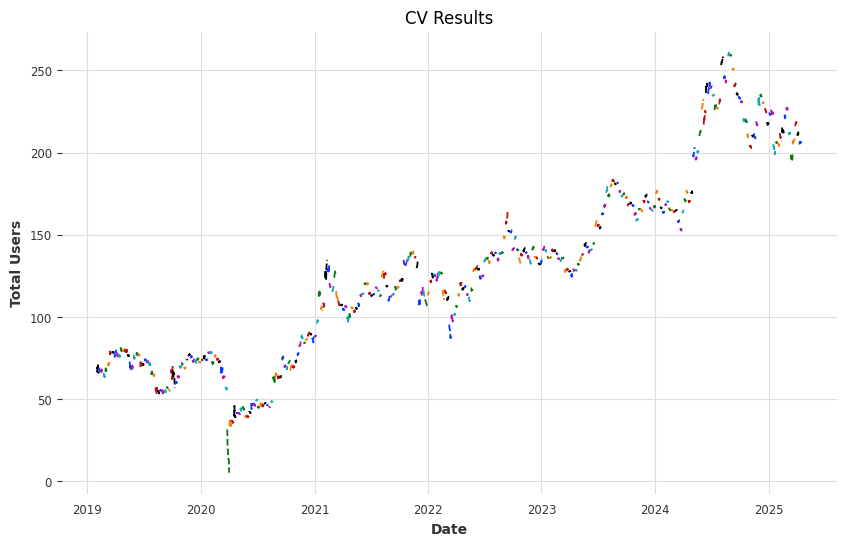

In [87]:
fig, ax = plt.subplots(figsize=(10,6))

# Loop through the cv
for i in range(len(cv)):
  predictions = TimeSeries.to_series(scaler1.inverse_transform(cv[i]))

  # Retrieve the actuals
  start = predictions.index.min()
  end = predictions.index.max()
  actuals = data.y[start:end]

  # Plot the predictions
  # ax.plot(actuals, label= f"actuals{i+1}")
  ax.plot(predictions, label = f"predictions{i+1}", linestyle="dashed")
# ax.legend()
# ax.plot(data.y, label = "actuals")
ax.set_title("CV Results")
ax.set_xlabel("Date")
ax.set_ylabel("Total Users")
plt.show()

In [88]:
import torch

# Save model weights
torch.save(model.model.state_dict(), "/content/drive/MyDrive/BTP/tsmixer_weights.pth")

In [89]:
model1 =TSMixerModel(
    input_chunk_length = 14,
    output_chunk_length = 7,
    add_encoders = add_encoders,
    ff_size = 9,
    num_blocks = 8,
    hidden_size=5,
    n_epochs = 10,
    use_reversible_instance_norm = True,
    pl_trainer_kwargs = {"accelerator":"gpu", "devices":[0]}
)
history = model1.fit(series=series_scaled[:-7], past_covariates=past_covariates_scaled[:-7])

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params | Mode 
--------------------------------------------------------------------
0  | criterion             | MSELoss          | 0      | train
1  | train_criterion       | MSELoss          | 0      | train
2  | val_criterion         | MSELoss          | 0      | train
3  | train_metrics         | MetricCollection | 0      | train
4  | val_metrics           | MetricCollection | 0      | train
5  | rin                   | RINorm           | 2      | train
6  | fc_hist               | Linear           | 105    | train
7  | feature_mixing_hist   | _FeatureMixing   | 624

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [90]:
from darts.metrics import mape
y_pred = model1.predict(n=7)
print(mape(series_scaled[-7:], y_pred))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

1.897355664315034
